Reference: Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018). Piasecka, B. et al. Distinctive roles of age, sex, and genetics in shaping transcriptional variation of human immune responses to microbial challenges. Proc. Natl. Acad. Sci. 115, E488-E497 (2018). и http://www.milieuinterieur.fr/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
%matplotlib inline

Данный датасет представляет собой рнк-секвенирование иммуного ответа пациентов на различные стимулы  (Escherichia coli, BCG, Staphylococcus aureus, SEB, Candida albicans and Influenza virus). В данном исследование были секвенированы 560 генов. Основная задача - оценить, насколько может быть вариабелен иммунный ответ в рамках популяции (пусть даже выборка тут небольшая)

Первые колонки, которые в своем названии содержат MFI - это не гены, это усредненный показатель наличиние антитела Н в популяции клеток К. Например, CD38_MFI_in_Bcells  показывает уровень CD38 в B-лимфоцитах. Данные показатели и будут показывать "уровень" имунного ответа. Чем больше этот показатель - тем больше клеток такого типа мы наблюдаем. 
В данной работе мы сосредоточимся на следующийх генах - IFNA2 (возраст) IFNG(возраст),  MAPK14, GATA3

In [2]:
dt = pd.read_csv('dataset_merged.txt',sep='\t')
dt.head()

,id,MFI_CD16_in_CD16hi_of_NKnew.panel4,MFI_CD16_of_CD56hi_of_NKnew.panel4,MFI_CD69_in_CD16hi.panel4,MFI_CD69_in_CD56hi.panel4,MFI_CD8a_in_CD16hi.panel4,MFI_CD8a_in_CD56hi.panel4,MFI_HLADR_in_CD16hi.panel4,MFI_HLADR_in_CD56hi.panel4,MFI_NKp46_of_NK_cells.panel4,...,GUSB,HPRT1,OAZ1,POLR1B,POLR2A,PPIA,RPL19,SDHA,TBP,stimulus
0,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.539184,9.394277,12.764243,6.876416,9.436988,7.149816,13.905253,7.594909,8.345415,E.coli
1,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.383923,8.645649,12.621510,5.879742,9.246874,7.109284,13.705402,7.602972,7.897460,NS
2,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.981202,9.393463,12.731546,6.761389,9.501816,7.038248,13.986449,7.607074,8.415745,S.aureus
3,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.167420,8.826709,12.313861,6.004913,9.191683,6.747720,13.113442,7.184175,8.011676,IAV
4,2,31186.0,1910.0,605.0,660.0,4654.0,1446.0,478.0,117.0,2596.0,...,6.319617,9.093092,12.859986,6.586251,9.716243,7.125948,14.220541,7.299251,8.183092,BCG


Проведем небольшую разминку - построим графики, посмотрим на распределения, проведем тесты, посчитаем статистики. 

У нас есть дополнительная информация. Самые интересные из колонок:
 - Age
 - PhysicalActivity
 - Sex
 - MetabolicScore
 - HoursOfSleep
 - UsesCannabis
 - Smoking
 - BMI

 Посмотрим на распределение возрастов и пола

In [3]:
metadata_columns = ['id','Age','PhysicalActivity','Sex','MetabolicScore','BMI','HoursOfSleep','UsesCannabis',\
                    'Smoking','Employed','Education','DustExposure']
ids_description  = dt.drop_duplicates('id').drop(['stimulus'],axis=1)[metadata_columns]
ids_description.head()

,id,Age,PhysicalActivity,Sex,MetabolicScore,BMI,HoursOfSleep,UsesCannabis,Smoking,Employed,Education,DustExposure
0,2,22.33,3.0,Female,0,20.13,9.00,No,Never,No,PhD,No
7,3,28.83,0.0,Female,1,21.33,7.05,No,Active,Yes,Baccalaureat,No
14,4,23.67,0.0,Female,2,22.18,6.50,Yes,Active,Yes,Baccalaureat,Current
21,5,21.17,0.5,Female,0,18.68,10.00,No,Never,No,PhD,No
28,8,26.17,1.5,Female,1,29.01,9.00,No,Never,Yes,Baccalaureat,No


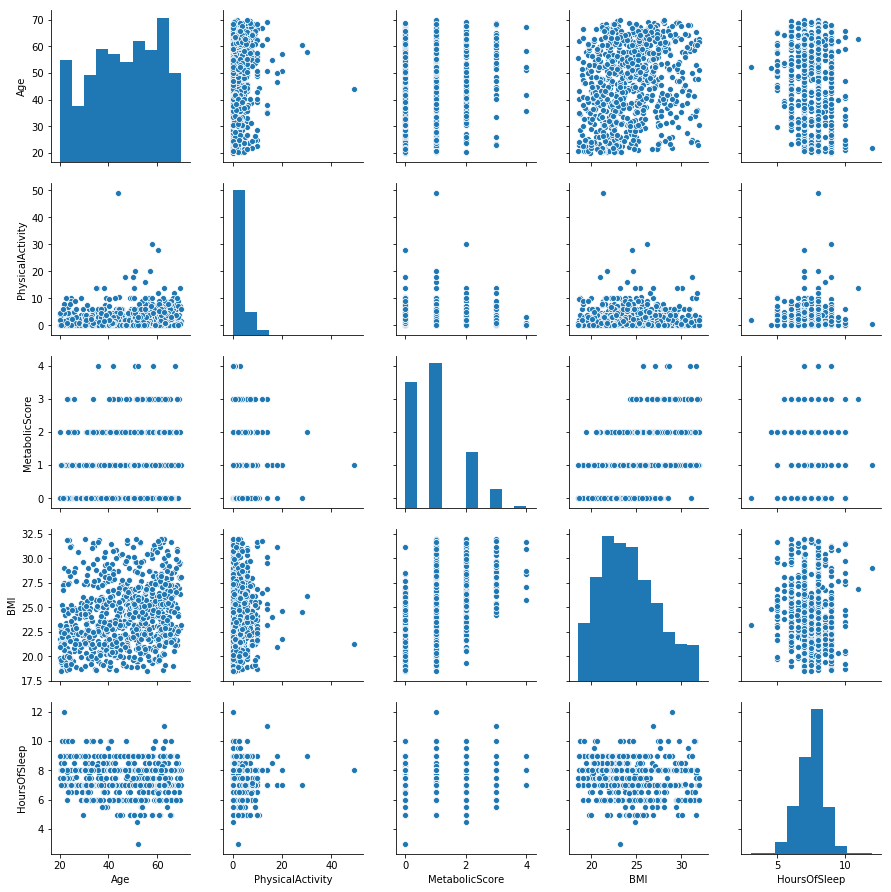

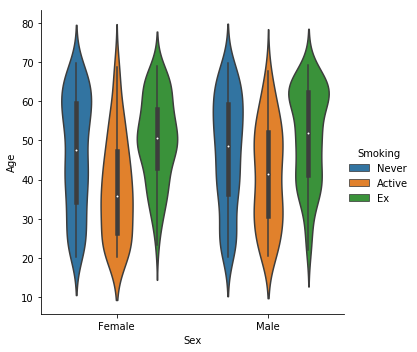

In [4]:
sns.pairplot(ids_description[['Age','PhysicalActivity','MetabolicScore','BMI','HoursOfSleep']]);
plt.show()
sns.catplot(x="Sex", y="Age", hue="Smoking",data=ids_description,kind="violin");

В принципе, данные довольно сбалансированные. Не удивительно, ведь авторы исследования так и пытались сделать. 
Теперь начнем смотреть на экспрессии генов и их связь с возрастом\полом\статусом.

3.1 Сравнение экспресии IFNG у мужчин и женщин

3.1.1 Рассмотрим распределение экспресси IFNG у женщин (со стимулом - S.aureus). На что похоже это распределение? Как это проверить? 

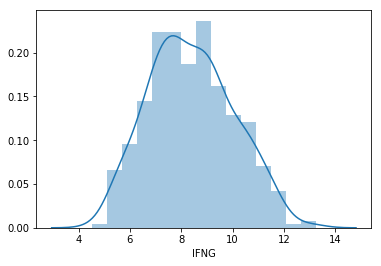

In [5]:
mask = (dt['Sex']=='Female') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG']);

Какое удивительное нормальные распределение! Давайте проверим, что оно нормальное

p value 0.005840549245476723


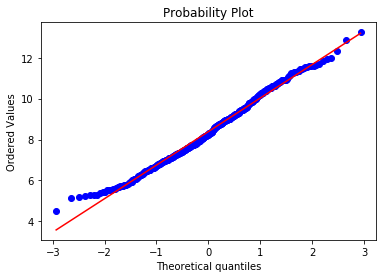

In [6]:
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
sc.stats.probplot(dt.loc[mask,'IFNG'].values,plot=plt);

In [7]:
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
print('mean {}, var {}'.format(d_mean, d_var))

mean 8.38686991239565, var 2.6778212676547954


 Оценим параметры этого распределения.

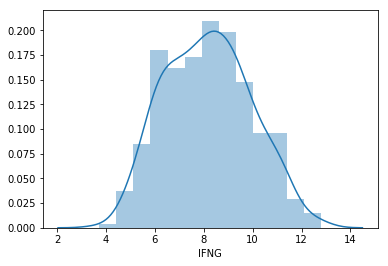

In [8]:
mask = (dt['Sex']=='Male') & (dt['stimulus']=='S.aureus')
sns.distplot(dt.loc[mask,'IFNG']);

p value 0.008007435128092766


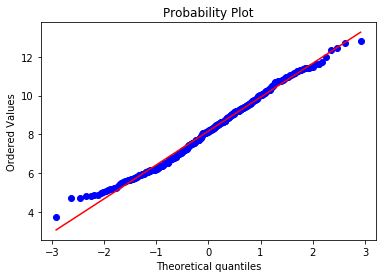

In [9]:
k2, p = sc.stats.shapiro(dt.loc[mask,'IFNG'].values)
print('p value {}'.format(p))
sc.stats.probplot(dt.loc[mask,'IFNG'].values,plot=plt);

Задача 1. Сделать аналогичные шаги для мужчин (со стимулом - S.aureus)

In [10]:
d_var = np.var(dt.loc[mask,'IFNG'].values)
d_mean = np.mean(dt.loc[mask,'IFNG'].values)
print('mean {}, var {}'.format(d_mean, d_var))

mean 8.169332888011015, var 3.049249527483538


Задача 2. Давайте используем бустреп чтобы оценить доверительный интервал для среднего уровня экспресии гена
IFNG у мужчин и женщин. Используем 1000 итераций, будем семплить по 100 точек. Давайте условимся, что в этот раз работаем со стимулом E.coli

In [23]:
stats = {"Male" : list(), "Female" : list()}
n_iterations = 1000
n_size = 100
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = mean(a)
    m, s = np.mean(a), sc.stats.sem(a)
    h = se * sc.stats.t.ppf((1 + confidence) / 2.0, n-1)
    return m, m-h, m+h
for idx, sex in enumerate(['Male', 'Female']):
    mask = (dt['Sex'] == sex) & (dt['stimulus'] == 'E.coli')
    values_expression = dt.loc[mask, 'IFNG'].values()
    

Выглядит так, будто экспрессия и правда различна. Давайте посмотрим на совместное распределение. В этом нам поможет violin plot

In [11]:
#plot IFNG by sex


Сложно сказать однозначно... Что тут можно сделать? 

Задача 3. Проверим, является ли различие в средней экспресии IFNG у мужчин и женщин при E.coli статистически значимым.
Каким тестом тут лучше воспользоваться и почему?  (при уровне значимости $\alpha  = 0.05$)

In [12]:
#Task 3 solution
scipy.stats.mannwhitneyu()

Задача 4. А интересно, у скольки еще генов различие в средней экспресии у мужчин и женщин при E.coli статистически значимым (при уровне значимости $\alpha  = 0.05$). Не будем усложнять себе жизнь и воспользуемся поправкой Бонферрони

In [13]:
#Task 4 solution

Отлично, но вернемся к IFNG. Добавим к рассмотрниею следующие параметры - Age, PhysicalActivity, BMI, Smoking, Education, LivesWithPartner. Как можно заметить, некоторые из них категориальные, некоторые - числовые. Тем интересней!

Задача 5. Рассмотрите уровень экспресии IFNG (при E.coli)  в зависимости от каждого из вышеназванных параметров. 
Какой вывод можно сделать? А если дополнительно разбить с учетом пола? 

In [14]:
#Task 5 solution

Задача 6. Для того, чтобы рассматривать экспрессию между несколькими группами, нам понадобится знание диспресионного анализа. 
Проверьте, можем ли мы утверждать, что уровень экспресии IFNG не зависит от курения (без разбиения по полу) (используейте пакет $statsmodels$). Дополнительно проведите Tukey hsd чтобы оценить разницу между группами

In [15]:
#Task 6 solution

В последующих шагах по постараемся воспроизвести основные результаты статьи  Piasecka, E. et al. Natural variation in the parameters of innate immune cells is preferentially driven by genetic factors resource. Nat. Immunol. 19, 302-314 (2018), опубликованной в Nature Genetics. Далее мы работаем с стимулом NS, то есть с изначальным иммуным ответом.

In [16]:
dt_ns  = dt.loc[dt['stimulus']=='NS',:]

Большое Задание 1. Рассмотрите зависимости между предложенными негентическими переменными в этом датасете. Для это сделаете попарные линейные модели и в качестве зависимости возьмите $R^2$. При работе с категориальными переменными, используйте OHE стратегию и используйте их только как предикторы. (Хотя в случае бинарного лейбла можно сделать логрегрессию)

In [17]:
nongenetic_columns = ['Age', 'OwnsHouse',
                      'PhysicalActivity', 'Sex', 'LivesWithPartner', 'LivesWithKids',
                      'BornInCity', 'Inbreeding', 'BMI', 'CMVPositiveSerology', 'FluIgG',
                      'MetabolicScore', 'LowAppetite', 'TroubleConcentrating',
                      'TroubleSleeping', 'HoursOfSleep', 'Listless', 'UsesCannabis',
                      'RecentPersonalCrisis', 'Smoking', 'Employed', 'Education',
                      'DustExposure', 'Income',
                      'DepressionScore', 'HeartRate',
                      'Temperature']

In [18]:
#Big task 1 solution

Большое задание 1.1. Теперь мы посмотрим на корреляцию между различными MFI. Это нужно, чтобы дальше мы взяли в работу только нескореллированные признаки

In [19]:
MFI_cols = [x for x in dt_ns.columns.values if 'MFI_' in x]

In [20]:
#Big task 1.1 solution 

Большое задание 2. Теперь сделаем регресионные модели для каждого из этих показателей.

In [21]:
factors = ['Age', 'Sex', 'BMI', 'CMVPositiveSerology', 'MetabolicScore', 'Smoking']
dt_ns_regres = dt_ns[factors+noncorrelated_features]

NameError: name 'noncorrelated_features' is not defined

In [ ]:
#Big task 2 solutions